     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.1 MB/s eta 0:00:00
Mounted at /content/drive

Training with Asset=BIST, LSTM_units=512, Epochs=500 ...
Training IMF 1 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 2 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 3 of 9...
4/4 [==============================] - 1s 4ms/step
Training IMF 4 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 5 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 6 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 7 of 9...
4/4 [==============================] - 1s 5

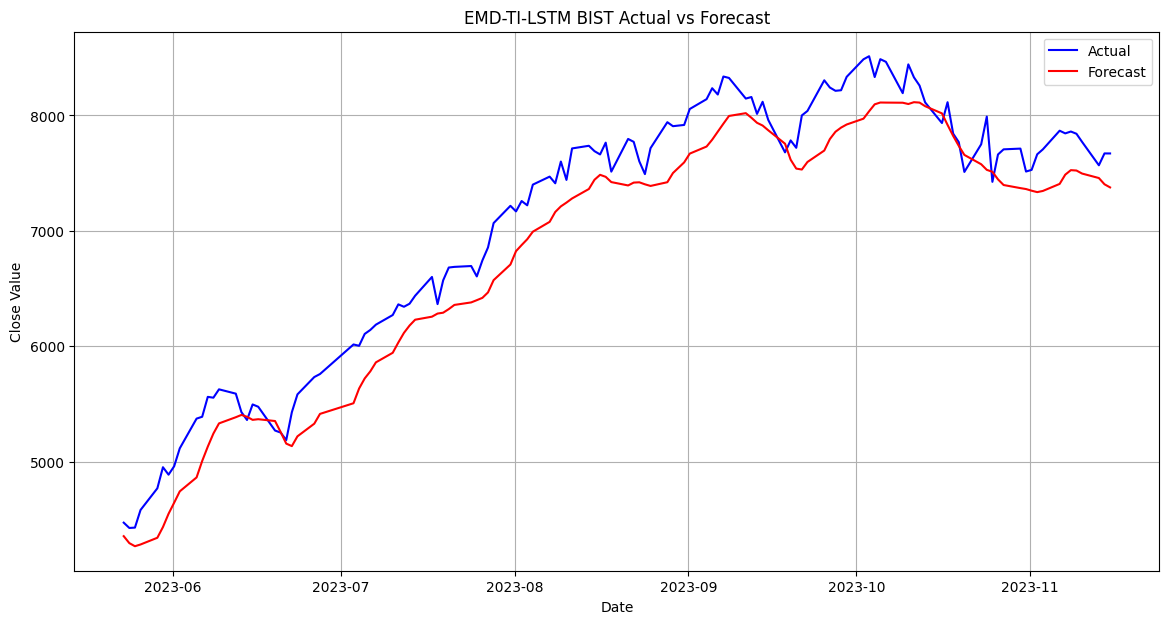


Training with Asset=BIST, LSTM_units=512, Epochs=500 ...
Training IMF 1 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 2 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 3 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 4 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 5 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 6 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 7 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 8 of 9...
4/4 [==============================] - 1s 5ms/step
Training IMF 9 of 9...
4/4 [==============================] - 1s 5ms/step
Results are MAPE: 3.47%, RMSE: 273, MAE: 242



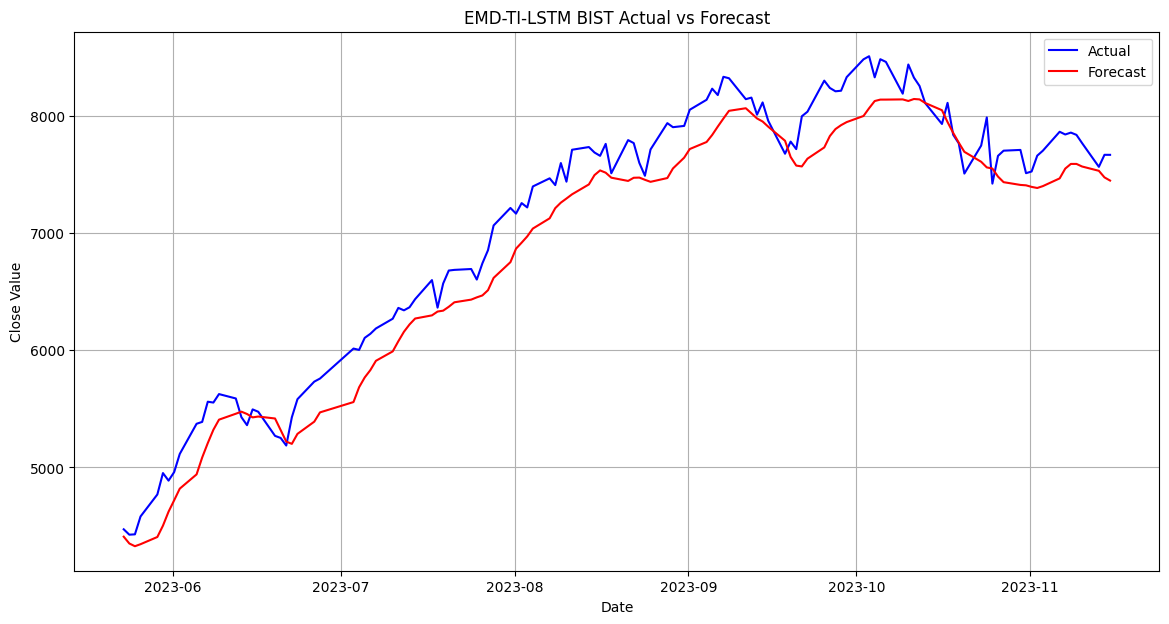

Execution completed and results saved to local and drive
Execution duration: 43.79 minutes


In [ ]:
import time
start_time = time.time()
!pip install EMD-signal -q
from PyEMD import EMD
import numpy as np
import pandas as pd
import tensorflow as tf
import itertools
import os
import shutil
import openpyxl
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt
from openpyxl.styles import Alignment
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
drive.mount('/content/drive')
tf.keras.backend.set_floatx('float32') # Setting the default data type for TensorFlow tensors


Assets = ["BTC", "BIST", "NASDAQ", "GOLD"]  # List of assets to train on "BTC", "BIST", "NASDAQ", "GOLD"
Time_interval = "D"  # Time interval for the dataset
Lstm_units_range = [512]
Epochs_range = [500]
Sequence_length_range = [60]
Train_test_ratio_range = [0.95]
Dropout_ratio_range = [0.1]
TI_window_range = [7]
Batch_size = 32  # Batch size for training the model
learning_rate = 0.0001  # Learning rate for the model
Loss_function = 'mean_squared_error'  # Loss function for the model
Activation_function = 'tanh'  # Activation function for LSTM layers
filename = 'EMD-TI-LSTM evaluation_results 0702_2.xlsx'
google_drive_path = '/content/drive/My Drive/Code_Results/EMD-TI-LSTM evaluation_results.xlsx'



# Main processing loop for each asset
for Asset in Assets:
      # Iterate over combinations of hyperparameters
    for lstm_units, epochs, sequence_length, train_test_ratio, dropout_ratio, ti_window in itertools.product(
    Lstm_units_range, Epochs_range, Sequence_length_range, Train_test_ratio_range, Dropout_ratio_range, TI_window_range):
        # Printing the configuration being trained
        print(f"\nTraining with Asset={Asset}, LSTM_units={lstm_units}, Epochs={epochs} ...")

        Optimizer = Adam(learning_rate=learning_rate)

        # Load data from Excel file for the specific asset and time interval
        xlsx_file_path = f"/content/drive/My Drive/Master_Data/Last/{Asset}_{Time_interval}.xlsx"
        data = pd.read_excel(xlsx_file_path)
        data['Date'] = pd.to_datetime(data['Date'])
        data = data.sort_values('Date')
        close_values = data['Close'].values

        # Apply EMD
        emd = EMD()
        imfs = emd(close_values)

        # Prepare the data with sequence length
        def prepare_data(combined_data, sequence_length):
            scaler = MinMaxScaler(feature_range=(0, 1))
            combined_data_scaled = scaler.fit_transform(combined_data)

            X, y = [], []
            for i in range(sequence_length, len(combined_data_scaled)):
                X.append(combined_data_scaled[i-sequence_length:i])
                y.append(combined_data_scaled[i, 0])
            X, y = np.array(X), np.array(y)

            return X, y, scaler

        # Define the LSTM Model
        def create_lstm_model(input_shape):
            model = Sequential([
                LSTM(units=lstm_units, return_sequences=True, activation=Activation_function, input_shape=input_shape),
                Dropout(dropout_ratio),
                #LSTM(units=lstm_units, return_sequences=True, activation=Activation_function),
                #Dropout(dropout_ratio),
                LSTM(units=lstm_units, activation=Activation_function),
                Dropout(dropout_ratio),
                Dense(1)
            ])
            model.compile(optimizer=Adam(learning_rate=0.0001), loss=Loss_function)
            return model

        # Initialize lists to collect all predictions and actual values
        all_forecasts = []

        # Train the Model and Make Predictions for each IMF
        for idx, imf in enumerate(imfs):
            print(f"Training IMF {idx + 1} of {len(imfs)}...")  # Print the current IMF being trained
            imf_series = pd.Series(imf)

            # Calculate EMA and Bollinger Bands for the IMF
            ema = imf_series.ewm(span=ti_window, adjust=False).mean()
            sma = imf_series.rolling(window=ti_window).mean()
            std_dev = imf_series.rolling(window=ti_window).std()
            bollinger_upper = sma + (std_dev * 2)
            bollinger_lower = sma - (std_dev * 2)

            def calculate_rsi(data, window=ti_window):
                delta = data.diff()
                gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
                loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

                rs = gain / loss
                rsi = 100 - (100 / (1 + rs))
                return rsi

            rsi = calculate_rsi(imf_series, window=ti_window)

            # Combine IMF, EMA, and Bollinger Bands into a single DataFrame
            combined_data = pd.DataFrame({
                'EMA': ema,
                'Bollinger Upper': bollinger_upper,
                'Bollinger Lower': bollinger_lower,
                'RSI': rsi,
                'IMF': imf,
            }).dropna().values

            X, y, scaler = prepare_data(combined_data, sequence_length)

            train_size = int(len(X) * train_test_ratio)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]

            model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
            model.fit(X_train, y_train, epochs=epochs, batch_size=Batch_size, shuffle=False, validation_split=0.1,
                      callbacks=[EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)], verbose=0)

            forecasts = model.predict(X_test)
            forecasts_inverse = scaler.inverse_transform(np.column_stack((np.zeros_like(X_test[:, -1, :-1]), forecasts)))[:, -1]

            # Store forecasts
            all_forecasts.append(forecasts_inverse.flatten())


        # Ensure all arrays are of the same length
        aggregated_forecasts = np.sum(all_forecasts, axis=0)

        # Split the close prices into training and testing sets
        close_prices = data['Close'].values
        test_close_prices = close_prices[-len(aggregated_forecasts):]  # Align with your test dataset

        # Ensure the dates are aligned as well
        date_series = data['Date'].values
        test_dates = date_series[-len(aggregated_forecasts):]


        def mean_absolute_percentage_error(y_true, y_pred):
            return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

        # Calculate metrics
        mape = mean_absolute_percentage_error(test_close_prices, aggregated_forecasts)
        mse = mean_squared_error(test_close_prices, aggregated_forecasts)
        rmse = sqrt(mse)
        mae = mean_absolute_error(test_close_prices, aggregated_forecasts)
        print(f'Results are MAPE: {mape:.2f}%, RMSE: {rmse:.0f}, MAE: {mae:.0f}\n')

        # Save results to Excel
        def save_results_to_excel(filename, Asset, Time_interval, lstm_units, epochs, sequence_length, ti_window,
                                  learning_rate, dropout_ratio, train_test_ratio, Batch_size, mape, rmse, mae):
            mape_formatted = "{:.2f}".format(mape).replace('.', ',')
            rmse_formatted = f"{rmse:.0f}"
            mae_formatted = f"{mae:.0f}"
            # Create a DataFrame with the results
            results_df = pd.DataFrame({
                'Model': ['EMD-TI-LSTM'],
                'Asset': [Asset],
                'Time Interval': [Time_interval],
                'LSTM Units': [lstm_units],
                'Epochs': [epochs],
                'Seq. Length': [sequence_length],
                'TI Window': [ti_window],
                'LR': [learning_rate],
                'Dropout': [dropout_ratio],
                'T/T Ratio': [train_test_ratio],
                'Batch Size': [Batch_size],
                'MAPE': [mape_formatted],
                'RMSE': [rmse_formatted],
                'MAE': [mae_formatted]
            })
            try:
                existing_df = pd.read_excel(filename)
                combined_df = pd.concat([existing_df, results_df], ignore_index=True)
            except FileNotFoundError:
                combined_df = results_df
            # Save DataFrame to an Excel file
            combined_df.to_excel(filename, index=False)
            # Load the Excel file
            workbook = openpyxl.load_workbook(filename)
            worksheet = workbook.active
            # Set a fixed size and center alignment for all columns
            for col in worksheet.columns:
                for cell in col:
                    cell.alignment = Alignment(horizontal='center')
        # Set a fixed size for all columns
            for column_cells in worksheet.columns:
                max_length = 12  # Set the desired fixed width for the column
                for cell in column_cells:
                    cell.alignment = Alignment(horizontal='center')
                    worksheet.column_dimensions[openpyxl.utils.get_column_letter(cell.column)].width = max_length
        # Save the workbook
            workbook.save(filename)
        # Check if the file exists locally
            if os.path.exists(filename):
                # Copy the file from local to Google Drive
                shutil.copy(filename, google_drive_path)
                #print(f"File copied to Google Drive at {google_drive_path}")
            else:
                print(f"Local file {filename} not found. Check the saving path.")
        save_results_to_excel(filename, Asset, Time_interval, lstm_units, epochs, sequence_length, ti_window,
                              learning_rate, dropout_ratio, train_test_ratio, Batch_size, mape, rmse, mae)

        # # Plot the aggregated forecasts
        plt.figure(figsize=(14, 7))
        plt.plot(test_dates, test_close_prices, label='Actual', color='blue')  # Use test_close_prices here
        plt.plot(test_dates, aggregated_forecasts, color='red', label='Forecast')
        plt.title(f'EMD-TI-LSTM {Asset} Actual vs Forecast')
        plt.xlabel('Date')
        plt.ylabel('Close Value')
        plt.legend()
        plt.grid(True)  # Add a grid
        plt.show()


# Print completion message
print(f'Execution completed and results saved to local and drive')
end_time = time.time()
duration_seconds = end_time - start_time
duration_minutes = duration_seconds / 60
print(f'Execution duration: {duration_minutes:.2f} minutes')